In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

import os
import torch
from torch import nn

from tqdm import tqdm
import glob

import json
import yaml

from models.models_factories import segmentation_nns_factory_dict

from train_nn import create_model

from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.patches as mpatches

from data import HSI_dataset

%matplotlib inline

c:\Users\admin\miniconda3\envs\deep_learning\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Seismic Sensors

In [ ]:
class_name2idx_dict = {
    'Unlabeled': 0,
    'Buildings': 1,
    'Applicable Ground': 2,
    'Applicable Grow': 3,
    'Applicable Wetland': 4,
    'Applicable Wood': 5,
    'Non-Applicable Ground': 6,
    'Non-Applicable Grow': 7,
    'Non-Applicable Wetland': 8,
    'Transport': 9,
    'Water': 10
}

class_idx2name_dict = {v:k for k, v in class_name2idx_dict.items()}

class_idx2color_dict = {
    0: '#000000', # 'Unlabeled'
    1: "#616161", # 'Buildings'
    2: "#fce300", # 'Applicable Ground'
    3: '#73ef35', # 'Applicable Grow'
    4: "#474D26", # 'Applicable Wetland'
    5: '#549b52', # 'Applicable Wood'
    6: "#F5F3A1", # 'Non-Applicable Ground'
    7: "#03ca03", # 'Non-Applicable Grow'
    8: '#8d854e', # 'Non-Applicable Wetland'
    9: "#CCCCCC", # 'Transport'
    10: '#5989e1' # 'Water'
}



{0: 'Unlabeled',
 1: 'Buildings',
 2: 'Applicable Ground',
 3: 'Applicable Grow',
 4: 'Applicable Wetland',
 5: 'Applicable Wood',
 6: 'Non-Applicable Ground',
 7: 'Non-Applicable Grow',
 8: 'Non-Applicable Wetland',
 9: 'Transport',
 10: 'Water'}

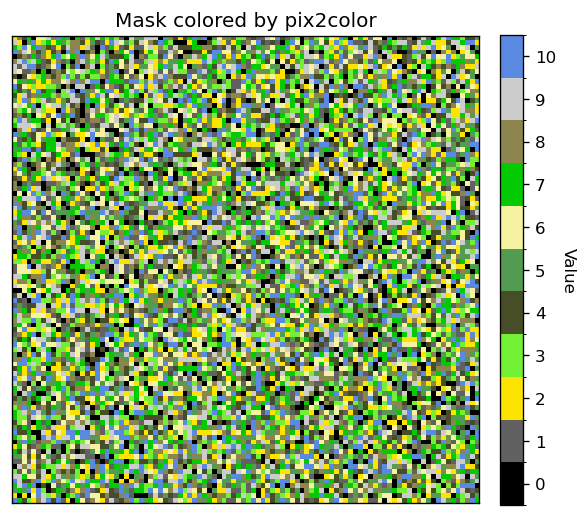

In [11]:


# Предполагается, что у вас уже есть:
# mask: np.ndarray формы (96, 96) с int значениями
# pix2color: dict вида {int_value: "#RRGGBB"}
pix2color = {
    0: '#000000', # 'Unlabeled'
    1: "#616161", # 'Buildings'
    2: "#fce300", # 'Applicable Ground'
    3: '#73ef35', # 'Applicable Grow'
    4: "#474D26", # 'Applicable Wetland'
    5: '#549b52', # 'Applicable Wood'
    6: "#F5F3A1", # 'Non-Applicable Ground'
    7: "#03ca03", # 'Non-Applicable Grow'
    8: '#8d854e', # 'Non-Applicable Wetland'
    9: "#CCCCCC", # 'Transport'
    10: '#5989e1' # 'Water'
}

mask = np.random.randint(0, 11, size=(96,96))


# 1) Проверим, что все значения в mask имеют цвет
vals_in_mask = np.unique(mask)
missing = [v for v in vals_in_mask if v not in pix2color]
if missing:
    raise ValueError(f"Для значений {missing} нет цветов в pix2color")

# 2) Отсортированный список дискретных значений и соответствующие цвета
values = sorted(pix2color.keys())
colors = [pix2color[v] for v in values]

# 3) Дискретная карта цветов и нормировка по «коробкам» вокруг целых
cmap = ListedColormap(colors, name="pixmap", N=len(colors))

# Границы по центрам между соседними целыми: [v0-0.5, v0+0.5, v1+0.5, ...]
boundaries = np.array(values, dtype=float)
boundaries = np.concatenate(([boundaries[0] - 0.5], (boundaries[:-1] + boundaries[1:]) / 2, [boundaries[-1] + 0.5]))
norm = BoundaryNorm(boundaries, cmap.N, clip=True)

# 4) Отрисовка
fig, ax = plt.subplots(figsize=(5, 5), dpi=120)
im = ax.imshow(mask, cmap=cmap, norm=norm, interpolation="nearest")
ax.set_title("Mask colored by pix2color")
ax.set_xticks([])
ax.set_yticks([])

# 5) Дискретный colorbar с метками именно ваших значений
cbar = plt.colorbar(im, ax=ax, ticks=values, fraction=0.046, pad=0.04)
cbar.ax.set_ylabel("Value", rotation=270, labelpad=12)

plt.tight_layout()
plt.show()

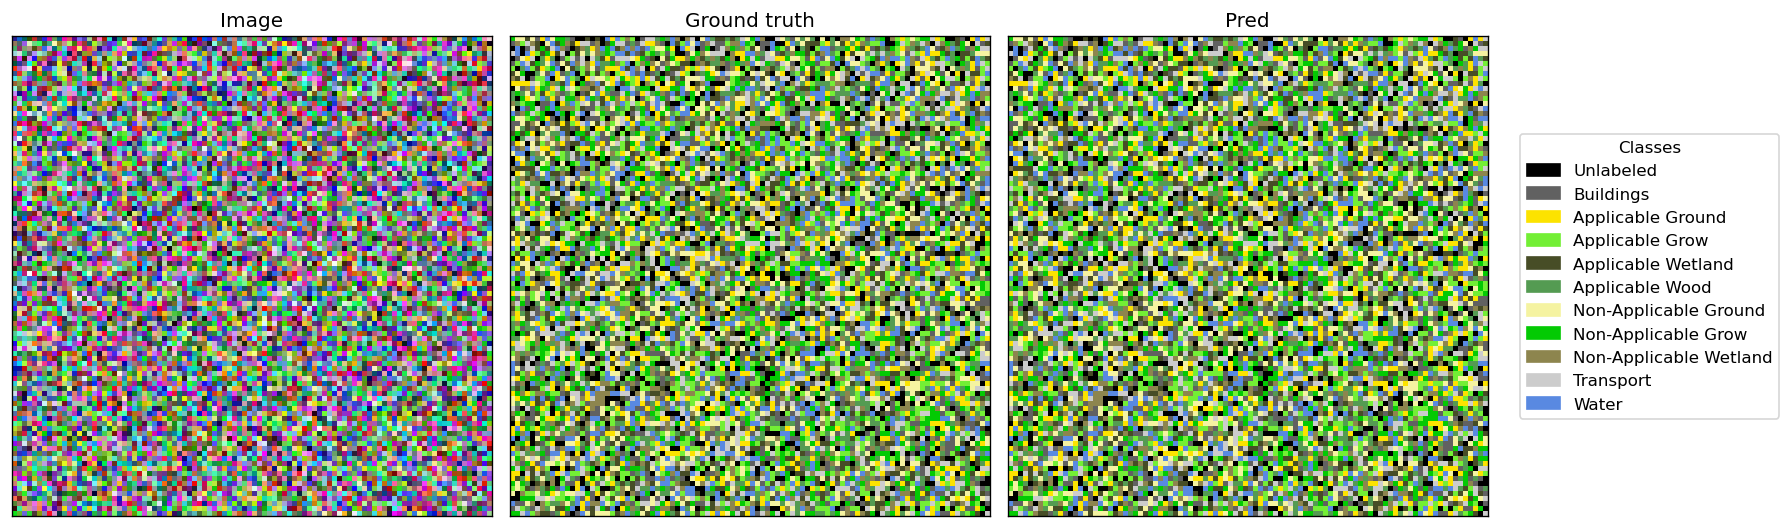

In [38]:
pix2class = {
    0: 'Unlabeled',
 1: 'Buildings',
 2: 'Applicable Ground',
 3: 'Applicable Grow',
 4: 'Applicable Wetland',
 5: 'Applicable Wood',
 6: 'Non-Applicable Ground',
 7: 'Non-Applicable Grow',
 8: 'Non-Applicable Wetland',
 9: 'Transport',
 10: 'Water'}

pix2color = {
    0: '#000000', # 'Unlabeled'
    1: "#616161", # 'Buildings'
    2: "#fce300", # 'Applicable Ground'
    3: '#73ef35', # 'Applicable Grow'
    4: "#474D26", # 'Applicable Wetland'
    5: '#549b52', # 'Applicable Wood'
    6: "#F5F3A1", # 'Non-Applicable Ground'
    7: "#03ca03", # 'Non-Applicable Grow'
    8: '#8d854e', # 'Non-Applicable Wetland'
    9: "#CCCCCC", # 'Transport'
    10: '#5989e1' # 'Water'
}
img = np.random.randint(0, 65536, size=(96,96,3))/65536
mask = np.random.randint(0, 11, size=(96,96))
gt_mask = np.random.randint(0, 11, size=(96,96))

vals_in_mask = np.unique(mask)
missing = [v for v in vals_in_mask if v not in pix2color]
if missing:
    raise ValueError(f"Нет цветов для значений: {missing}")

# Сортируем значения
values = sorted(pix2color.keys())
colors = [pix2color[v] for v in values]

# Создаём дискретную cmap и norm
cmap = ListedColormap(colors, name="pixmap", N=len(colors))
boundaries = np.array(values, dtype=float)
boundaries = np.concatenate((
    [boundaries[0] - 0.5],
    (boundaries[:-1] + boundaries[1:]) / 2,
    [boundaries[-1] + 0.5]
))
norm = BoundaryNorm(boundaries, cmap.N, clip=True)

# Рисуем маску
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 9), dpi=120)
im = axs[0].imshow(img)
axs[0].set_title("Image")
axs[0].set_xticks([])
axs[0].set_yticks([])

im = axs[1].imshow(gt_mask, cmap=cmap, norm=norm, interpolation="nearest")
axs[1].set_title("Ground truth")
axs[1].set_xticks([])
axs[1].set_yticks([])

im = axs[2].imshow(gt_mask, cmap=cmap, norm=norm, interpolation="nearest")
axs[2].set_title("Pred")
axs[2].set_xticks([])
axs[2].set_yticks([])

# Формируем список патчей для легенды
patches = [
    mpatches.Patch(color=pix2color[val], label=pix2class.get(val, str(val)))
    for val in values if val in vals_in_mask
]

# Добавляем легенду сбоку
axs[2].legend(
    handles=patches,
    loc='center left',
    bbox_to_anchor=(1.05, 0.5),
    title="Classes"
)

plt.tight_layout()
plt.show()

# HSI-UAV

In [2]:
def generate_grayscale_palette(size):
    max_val = 0xffffff
    step = max_val // size

    print(step)
    palette = []
    for i in range(0, max_val, step):
        palette.append(f'#{i:06x}')

    
    return palette

def draw_results(pix2color, pix2class, img, gt_mask, pred_mask, figsize, set_title, legend, transpose):
    vals_in_mask = np.unique(pred_mask)
    missing = [v for v in vals_in_mask if v not in pix2color]
    if missing:
        raise ValueError(f"Нет цветов для значений: {missing}")
    
    values = sorted(pix2color.keys())
    colors = [pix2color[v] for v in values]

    # Создаём дискретную cmap и norm
    cmap = ListedColormap(colors, name="pixmap", N=len(colors))
    boundaries = np.array(values, dtype=float)
    boundaries = np.concatenate((
        [boundaries[0] - 0.5],
        (boundaries[:-1] + boundaries[1:]) / 2,
        [boundaries[-1] + 0.5]
    ))
    norm = BoundaryNorm(boundaries, cmap.N, clip=True)

    # Рисуем маску
    if transpose:
        figsize = figsize[::-1]
        fig, axs = plt.subplots(nrows=3, ncols=1, figsize=figsize, dpi=120)
    else:
        fig, axs = plt.subplots(nrows=1, ncols=3, figsize=figsize, dpi=120)
    im = axs[0].imshow(img)
    if set_title:
        axs[0].set_title("Image")
    axs[0].set_xticks([])
    axs[0].set_yticks([])

    im = axs[1].imshow(gt_mask, cmap=cmap, norm=norm, interpolation="nearest")
    if set_title:
        axs[1].set_title("Ground truth")
    axs[1].set_xticks([])
    axs[1].set_yticks([])

    im = axs[2].imshow(pred_mask, cmap=cmap, norm=norm, interpolation="nearest")
    if set_title:
        axs[2].set_title("Pred")
    axs[2].set_xticks([])
    axs[2].set_yticks([])

    # Формируем список патчей для легенды
    patches = [
        mpatches.Patch(color=pix2color[val], label=pix2class.get(val, str(val)))
        for val in values if val in vals_in_mask
    ]
    if legend:
        # Добавляем легенду сбоку
        axs[2].legend(
            handles=patches,
            loc='center left',
            bbox_to_anchor=(1.05, 0.5),
            title="Classes"
        )

    plt.tight_layout()
    plt.show()

# Генерация палитры из 5 цветов
palette = generate_grayscale_palette(30)
palette = [
    '#FF0000',
    '#00FF00',
    '#0000FF',
    '#FFFF00',
    '#FF00FF',
    '#00FFFF',
    '#FF8000',
    '#8000FF',
    '#00FF80',
    '#FF0080',
    '#80FF00',
    '#0080FF',
    '#FF4040',
    '#40FF40',
    '#4040FF',
    '#FFFF40',
    '#FF40FF',
    '#40FFFF',
    '#FF8040',
    '#8040FF',
    '#40FF80',
    '#FF4080',
    '#80FF40',
    '#4080FF',
    '#FFC0C0',
    '#C0FFC0',
    '#C0C0FF',
    '#FFFFC0',
    '#FFC0FF',
    '#C0FFFF',
]
palette = {i: c for i, c in enumerate(palette)}
pix2class = {i:f'{i}' for i in palette.keys()}


559240


In [3]:
path_to_model_config = r'C:\Users\mokhail\develop\MultispectralSegmentation\saving_dir\unet_tu-cspdarknet53_HSI 2025-10-25T22-28-00\training_config.yaml'
path_to_model_config = r'z:\mikhail_u\HSI_ref_results\unet_aux_att_tu-cspdarknet53_HSI_chatt_300ep 2025-11-04T03-57-38\training_config.yaml'
path_to_weights = glob.glob(os.path.join(os.path.split(path_to_model_config)[0], '*.ckpt'))[0]
with open(path_to_model_config) as fd:
    config_dict = yaml.load(fd, yaml.Loader)

model_state_dict = torch.load(path_to_weights)['state_dict']
# Необходимо удалить имя верхнего уровеня в state dict
model_state_dict = {'.'.join(k.split('.')[1:]): w for k, w in model_state_dict.items()}

model = create_model(config_dict, segmentation_nns_factory_dict)
model.load_state_dict(model_state_dict)
model = model.to(config_dict['device'])
model.eval()
print()

In [13]:
def normalize(band):
    band_min, band_max = band.min(), band.max()
    return (band - band_min) / (band_max - band_min)


def pseudo_rgb(img):
    # Выберите каналы для R, G, B. Номера зависят от длин волн.
    red_channel = 150    # Близко к 700 нм
    green_channel = 100  # Близко к 550 нм
    blue_channel = 50    # Близко к 450 нм

    # Извлечение каналов и нормализация значений
    red = img[red_channel].astype(float)
    green = img[green_channel].astype(float)
    blue = img[blue_channel].astype(float)
    red_n = normalize(red)
    green_n = normalize(green)
    blue_n = normalize(blue)

    # Создание RGB изображения
    rgb_image = np.dstack((red_n, green_n, blue_n))
    return rgb_image

def pseudo_rgb2(cube, rgb_wls=(640,550,470), stretch_percentiles=(2,98)):
    #def visualize_hsi_cube(cube, wavelengths, rgb_wls=(640,550,470), stretch_percentiles=(2,98)):
    ##import numpy as np
    #import matplotlib.pyplot as plt

    B = cube.shape[2]
    wavelengths = np.linspace(400, 1000, B)

    H, W, B = cube.shape
    # найти индексы для RGB
    idx_r = np.argmin(np.abs(wavelengths - rgb_wls[0]))
    idx_g = np.argmin(np.abs(wavelengths - rgb_wls[1]))
    idx_b = np.argmin(np.abs(wavelengths - rgb_wls[2]))
    print("Using bands:", idx_r, idx_g, idx_b, wavelengths[idx_r], wavelengths[idx_g], wavelengths[idx_b])

    rgb = np.stack([cube[idx_r], cube[idx_g], cube[idx_b]], axis=2)
    print(cube[:,:,idx_r].shape)
    p_low, p_high = stretch_percentiles
    rgb_norm = (rgb - np.percentile(rgb, p_low)) / (np.percentile(rgb, p_high) - np.percentile(rgb, p_low))
    rgb_norm = np.clip(rgb_norm, 0, 1)

    return rgb_norm

In [ ]:
path_to_dataset_root= r'C:\Users\admin\python_programming\DATA\UAV-HSI-Crop-Dataset'

test_dataset = HSI_dataset(
        path_to_dataset_partition=os.path.join(path_to_dataset_root, 'Test'),
        augmentation_transforms=nn.Identity(),
        device=torch.device('cuda')
        )

dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

model.eval()
print('PIDR')

for imgs, gr_true in tqdm(dataloader):
    with torch.no_grad():
        pred = model(imgs)
    pred = pred.argmax(dim=1).squeeze(0).cpu().numpy()
    gr_true = gr_true.squeeze(0).cpu().numpy()
    imgs = imgs.squeeze(0).cpu().numpy()
    rgb = pseudo_rgb(imgs)
    rgb = pseudo_rgb2(imgs)
    draw_results(
        pix2color=palette,
        pix2class=pix2class,
        img=rgb, gt_mask=gr_true, pred_mask=pred,
        figsize=(4,1.6),
        set_title=False,
        legend=False,
        transpose=False)


In [ ]:
draw_results(
    pix2color=palette,
    pix2class=pix2class,
    img=rgb, gt_mask=gr_true, pred_mask=pred,
    figsize=(5,2),
    set_title=False,
    legend=False,
    transpose=True)